<a href="https://colab.research.google.com/github/drscotthawley/DLAIE/blob/main/2025/AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Arsenal of Autoencoders: AE, VAE, Conditional VAE, VQ-VAE


## Outline:
1. Introduction
1. Setting Up
1. Autoencoder
1. Varational Autoencoder (VAE)
1. Conditional Variational Autoencoder (C-VAE)
1. Vector-Quantized Varational Autoencoder (VQ-VAE)

## Introduction

An autoencoder is a system that forces the input through some encoding "bottleneck" and then tries to reconstruct its input via it's decoding shape. The overall shape resembles and hourglass, and the encoded representation on the middle is often called a "latent space".  This naturally results in a kind of (lossy) compression, and thus it forces the network to learn a latent space representation of the important qualities of the data.

<img src="https://github.com/drscotthawley/DLAIE/blob/main/images/AutoEncoder.png?raw=true" height="400px">

An alternative representation can be seen in the diagram below:

![kenan_pic](https://pbs.twimg.com/media/GzjZJD1aMAAhJ_C?format=jpg&name=4096x4096)

> *Image source: [Kenan Crane](https://x.com/keenanisalive/status/1961559905850028341):
"I can't* fathom why the top picture, and not the bottom picture, is the standard diagram for an autoencoder.
The whole idea of an autoencoder is that you complete a round trip and seek cycle consistency—why lay out the network linearly?"

> Reply from [Hector Yee](https://x.com/eigenhector/status/1961603222499467427): "The first diagram can include denoising auto encoders. Harder to show that in the second diagram."

**NOTATION:** We will denote the input as $x$, and use $\widehat{x}$, `x_hat`, and `recon` interchangeably to denote the reconstructed output.

**VOCABULARY:** The [Manifold Hypothesis](https://en.wikipedia.org/wiki/Manifold_hypothesis) is the idea that, out of the space of all possible variations of data (say, pixels), most of the possibilities are "random noise", whereas the data one is likely to see in applications (e.g., real photographs) occupy a reduced-dimensional manifold (a connected *subspace*) within the larger space. Thus the learned Latent Space (built from the appropriate activation functiosn in the Encoder) can function as an approximation to such a manifold.  (For *true* manifold learning, cf. [UMAP](https://umap-learn.readthedocs.io/en/latest/).)

Unlike the U-Net, which computes the change in something and uses skip connections, the goal of an autoencoder is to learn a *compressed represenatation* of the data (i.e., the data distribution or manifold) by training on the goal of *reconstructing its input*, and there are no skip connections. If we were to include skip connections, they would "shortcut" (pun intended) the process of learning the compressed representation.
(Note: skip connections within the Encoder or within the Decoder could be ok, but there should be nothing connecting the two main sections other than the latent space.)

Autoencoders have been used for a variety of things over the years:
- **Keep the Encoder, Don't Use the Decoder:** As an "unsupervised learning" method (i.e., no labels needed), you could *pre-train* an Encodeer that you want to use for some downstream task (such as classification) by training an autoencoder and keeping only the Encoder part.
- **Learnable Codecs:** For communication protocols such as streaming audio or video, transmitting signals only in the latent space can result in very high compression ratios compared to traditional (rules-based) compression schemes because the ML codec is adapted to the specific kind of data it will be used for. Examples: SoundStream, Lira, DAC,...
- **Keep the Decoder, Don't Use the Encoder:** For generative models, sometimes one really wants just the Decoder part, so that you can generate new data in (small) latent space, and decode it to something useful.

There are various ways to do autoencoders and to apply the idea of an autoencoder to new tasks.  We will look at a few here.
Depending on the use case, the **"kind" of latent space** you construct can have properties that make it more amenable to certain tasks than others.  

*NOTE: Sometimes the term "autoencoder" is applied even if the output is not intended to match the input, but perhaps instead to be a modified form of the input.  This is because of the *similarity of the architecture* for computing changes, however we will retain the use of "autoencoder" to mean something that reconstructs its input.*

# 2. Setup

## Setup Imports

For this lesson, let's try [Pytorch Lightning](https://lightning.ai/docs/pytorch/stable/) as an alternative to raw Pytorch. (One approach is neither better nor worse than the other, this is just done to expose you to different frameworks.)

In [ ]:
# Uninstall Colab's bigframes because it conflicts with other installs
%pip uninstall -y bigframes
# Install Lightning, also let's use "rich" progress bars
%pip install -Uqq lightning wandb rich einops

Found existing installation: bigframes 2.21.0
Uninstalling bigframes-2.21.0:
  Successfully uninstalled bigframes-2.21.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 27.1 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn, optim, utils
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, RandomAffine, RandomErasing
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
# Not advocating Lightning over raw pytorch, but it offers some useful abstractions
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import RichProgressBar
import wandb
import numpy as np
from einops import rearrange

## Setup Dataset & DataLoaders

We'll use MNIST for this demo to keep things lightweight and simple

In [ ]:
# optional: define additional data augmentation transformers for the dataloader
train_transforms = torchvision.transforms.Compose([
    ToTensor(),
    # uncomment next lines for extra augmentations
    #RandomAffine(degrees=15, translate=(0.1, 0.1)),
    #RandomErasing(p=0.2, scale=(0.02, 0.1))
])

train_ds = MNIST(root='./data', train=True,  download=True, transform=train_transforms)
test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())
val_ds = test_ds  #alias val for test
print(f"Data set lengths: train: {len(train_ds)}, test: {len(test_ds)}")



batch_size = 128   # could make this bigger; note for MNIST on Colab we're disk-speed limited, not GPU-limited
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=2, shuffle=True, persistent_workers=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=2, shuffle=False, persistent_workers=True)
val_dl = test_dl # alias val <--> test

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.0MB/s]

Data set lengths: train: 60000, test: 10000


Inspect our data a bit..

y (target) = tensor([3, 8, 5, 1]) 
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = 0.0, max(x) = 0.9960784316062927
col 2: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 3: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0


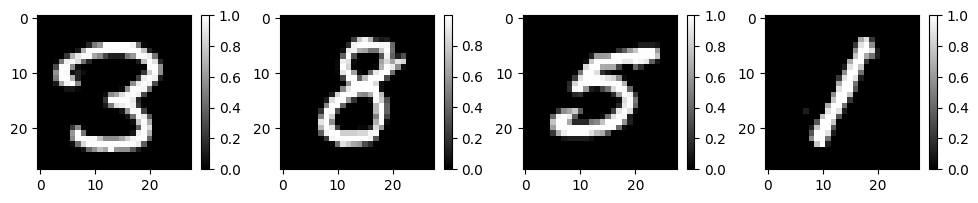

In [ ]:
# @title Code for `show_xs` visualization tool
def show_xs(xs, show_stats=True):
    """A little utility to show one or more images"""
    if type(xs) is not list: xs = list(xs)
    ncols = len(xs)
    fig, axs = plt.subplots(figsize=(3*ncols,2), ncols=ncols, squeeze=False)
    ax = axs.ravel()
    for col, x in enumerate(xs):
        if len(x.shape)>2: x = x[0] # remove any batch dimension
        if show_stats:
            if ncols > 1: print(f"col {col}: ",end="")
            print(f"x.shape = {tuple(x.shape)}, min(x) = {torch.min(x)}, max(x) = {torch.max(x)}")
        digit = ax[col].imshow(x.detach().cpu().numpy(), cmap='gray')
        fig.colorbar(digit, ax=ax[col])
    plt.show()

x, y = next(iter(train_dl))   # pick a few elements from the dataset
print(f"y (target) = {y[:4]} ")

show_xs(x[:4])

# 3. Autoencoder (aka "Vanilla Autoencoder")


First we'll try a regular autoencoder.
For the encoder and decoder, we could use convolutional layers, but MNIST images are small enough that we can get by with using `Linear` layers. Our architecture will thus resemble the first image in this notebook, above (albeit with more neurons).

In [ ]:
# instead of nn.Module, we use L.LightningModule
class AEModel(L.LightningModule):
    # The __init__ and forward are the basic PyTorch methods
    def __init__(self,
                 latent_dim=3,    # dimensionality of the latent space. bigger=less compression, better reconstruction
                 n_hid=[256,64],  # intermediate/hidden layers in our simple encoder/decoder
                 act = nn.LeakyReLU):
        super().__init__()

        self.encoder = nn.Sequential(
                        nn.Linear(28 * 28, n_hid[0]),
                        act(),
                        nn.Linear(n_hid[0], n_hid[1]),
                        act(),
                        nn.Linear(n_hid[1], latent_dim))
        self.decoder = nn.Sequential(
                        nn.Linear(latent_dim, n_hid[1]),
                        act(),
                        nn.Linear(n_hid[1], n_hid[0]),
                        act(),
                        nn.Linear(n_hid[0], 28 * 28),
                        #nn.Sigmoid(),        # optional. we *do* want outputs on [0,1]
                        )

        self.use_conv = False # just a flag to say we need to flatten for linear layers; not needed for conv layers

        self.latent_dim, self.n_hid, self.act = latent_dim, n_hid, act # store these config settings for "archival purposes" later
        print(f"Compression ratio = {28*28/latent_dim:.2f}x") # little note on how much compression we're getting

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return z, x_hat

    #------ That's really it for our model definition.
    #------ The remaining methods are used within the PyTorch Lightning training loop

    def do_pred(self, batch, batch_idx):
        "the basic task: make predictions, compute loss. Called by Lighting's Trainer"
        x, y = batch
        if not self.use_conv:
            x = x.view(x.size(0), -1)  # flatten for input to our linear layer
        z, recon = self.forward(x)
        loss = nn.functional.mse_loss(recon, x)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.do_pred(batch, batch_idx)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.do_pred(batch, batch_idx)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

    def on_validation_epoch_end(self, demo_every=1):
        if self.current_epoch % demo_every == 0:  # log every this many epochs
            fig = test_inference(self, idx=range(5), return_fig=True)  # note test_inference is defined below. catch-22.
            self.logger.experiment.log({"reconstructions": wandb.Image(fig), "epoch": self.current_epoch})
            plt.close(fig)  # clean up

autoencoder = AEModel()
model = autoencoder  # alias

Compression ratio = 261.33x


### Visualize the Reconstruction

Test the model to make sure we don't get any errors in the execution.  - Note that since the model is untrained right now, the reconstructions will be random.

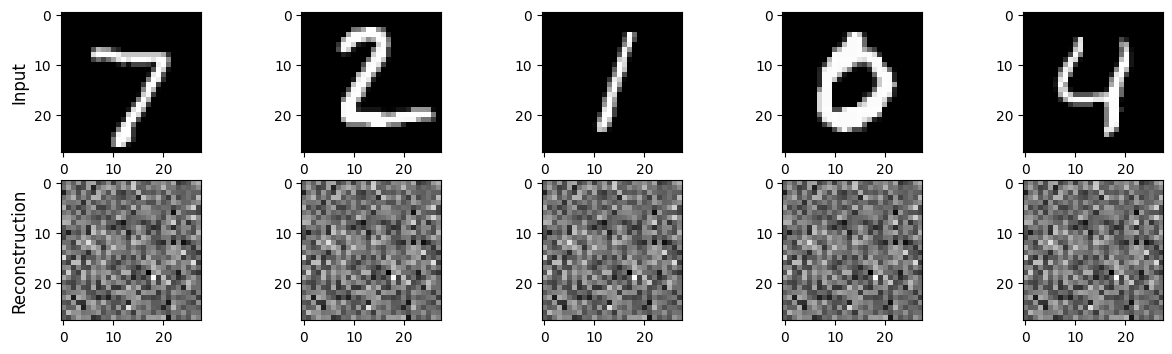

In [ ]:
# @title `test_inference` visualization code
@torch.no_grad()
def test_inference(model, idx=None, return_fig=False):
    import inspect
    model.eval()
    if idx is None: idx = torch.randint(len(test_ds), (1,))[0]
    if isinstance(idx, int): idx = [idx]
    elif isinstance(idx, range): idx = list(idx)
    x_batch = torch.stack([test_ds[i][0] for i in idx]).to(model.device)  # images
    y_batch = torch.tensor([test_ds[i][1] for i in idx]).to(model.device) # labels
    if not model.use_conv: x_batch = x_batch.view(x_batch.size(0), -1)
    if 1==len(inspect.signature(model.forward).parameters): # for ae or vae
        result = model.forward(x_batch)
    else:                                                   # c-vae (later in lesson)
        cond = F.one_hot(y_batch, num_classes=10).float()
        result = model.forward(x_batch, cond)
    z, recon = result[:2]
    recon = recon.view(len(idx), 28, 28)
    fig, axs = plt.subplots(2, len(idx), figsize=(3*len(idx), 4))
    if len(idx) == 1: axs = axs.reshape(2, 1)
    for i in range(len(idx)):
        axs[0,i].imshow(x_batch[i].view(28,28).cpu(), cmap='gray')
        axs[1,i].imshow(recon[i].cpu(), cmap='gray')
        if i == 0:
            axs[0,0].set_ylabel('Input', fontsize=12)
            axs[1,0].set_ylabel('Reconstruction', fontsize=12)
    model.train()
    if return_fig: return fig
    plt.show()

idx = range(5)
test_inference(autoencoder, idx=idx)

### Train the Model
We'll set up tracking via WandB and run the Lightning Trainer...

In [ ]:
wandb.login()
# Lightning defines its own WandbLogger callback...
wandb.finish() # just in case we're aborting runs & restarting

# set up the logging
wandb_logger = WandbLogger(log_model="all", project='ae_tut')
try:
    wandb_logger.watch(model)
except:
    pass

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: drscotthawley to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


The following is our training loop.  Lighting's [Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html) object is like the "Learner" from fast.ai and encapsulates the basic training logic we've seen in previous lessons.

In [ ]:
epochs = 15 # could train longer! just chose 15 for demo purposes
model.train()
trainer = L.Trainer(max_epochs=epochs, devices="auto",
                    callbacks=RichProgressBar(leave=True), logger=wandb_logger)
trainer.fit(model=autoencoder, train_dataloaders=train_dl, val_dataloaders=val_dl )
wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type       ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ encoder │ Sequential │  217 K │ train │
│ 1 │ decoder │ Sequential │  218 K │ train │
└───┴─────────┴────────────┴────────┴───────┘

Trainable params: 435 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 435 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 12                                                                                          
Modules in eval mode: 0

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▇▇▇▇▇▇▇▇███
train_loss,█▅▅▄▄▄▃▃▃▂▃▂▂▂▃▂▂▂▂▂▃▂▂▂▂▁▂▂▂▁▂▂▂▂▂▃▂▂▂▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▇▇▇▇▇▇██
val_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
epoch,14
train_loss,0.02963
trainer/global_step,7034
val_loss,0.03176


### Show Inference using the AutoEncoder

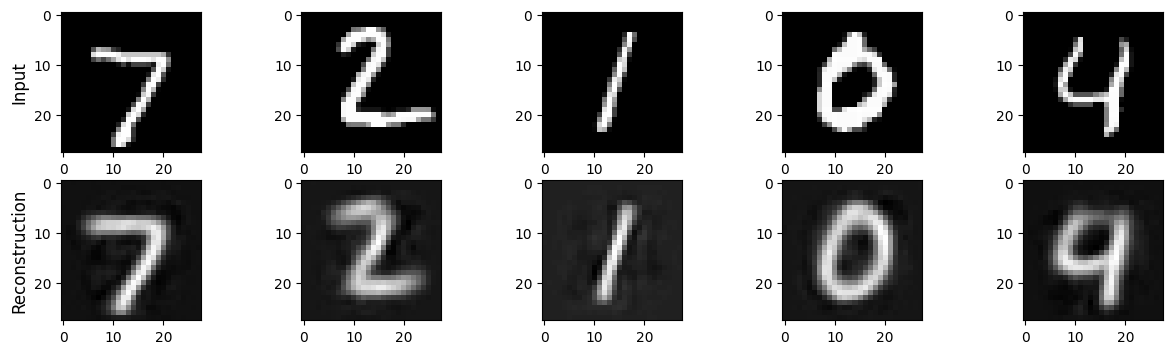

In [ ]:
test_inference(autoencoder, idx=range(5))

Notice how output is somewhat blurry. This is due to a combination of the latent space bottleneck which yields lossy compression, and because the Mean Squared Error (MSE) objective encouraged the model to learn to predict the mean. ...And also the fact that we stopped the training somewhat early.

Let's take a look at where the encoded points "live" in latent space (as a 2D projection via [PCA](https://drscotthawley.github.io/blog/posts/2019-12-21-pca-from-scratch.html)):

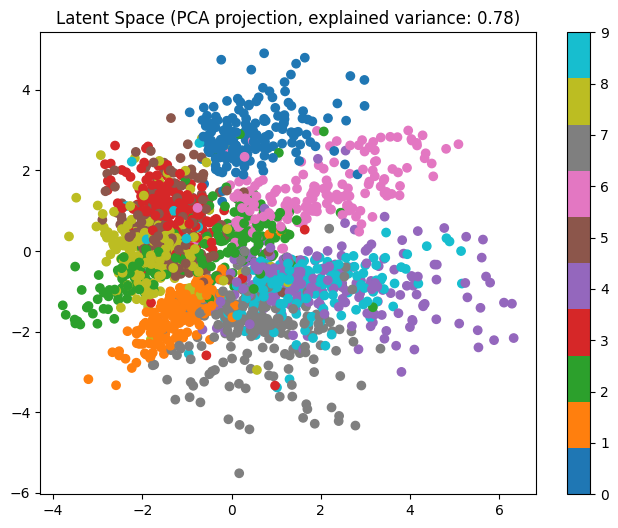

In [ ]:
#@title Code for viz tool `plot_latent_space`
@torch.no_grad()
def plot_latent_space(model, n_samples=2000):
    model.eval()
    zs, labels = [], []
    with torch.no_grad():
        for batch_idx, (x_batch, y_batch) in enumerate(test_dl):
            if len(zs) >= n_samples:
                break
            x_batch = x_batch.to(model.device)
            if not model.use_conv:
                x_batch = x_batch.view(x_batch.size(0), -1)
            z_batch = model.encoder(x_batch).cpu()
            if hasattr(model, 'reparam_sample') and z_batch.shape[-1] > model.latent_dim:  # VAE case
                z_batch = z_batch[:, :model.latent_dim]  # just use mu part
            zs.append(z_batch)
            labels.append(y_batch)

    zs = torch.cat(zs)[:n_samples].numpy()
    labels = torch.cat(labels)[:n_samples].numpy()


    if zs.shape[-1] > 2:  # we'll make a 2D plot regardless of how many dims are in the latent space
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        zs_2d = pca.fit_transform(zs)
        title = f"Latent Space (PCA projection, explained variance: {pca.explained_variance_ratio_.sum():.2f})"
    else:
        zs_2d = zs
        title = "Latent Space Visualization"

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(zs_2d[:, 0], zs_2d[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.title(title)
    model.train()
    plt.show()


plot_latent_space(autoencoder)

## Exercise 1: Vary `latent_dim`

Investigate the effects of the size of latent space. Go back and retrain the model with `latent_dim` as high as 64.  We chose 2 for visualization purposes (below).

> With `latent-dim=3` you could plot activations in 3D using [Plotly scatter plots](https://plotly.com/python/3d-scatter-plots/)! You could even compare this latent space to what you get from [Principal Component Analyss (PCA)](https://drscotthawley.github.io/blog/posts/2019-12-21-pca-from-scratch.html)! The main difference here being that the Decoder allows our latent space values to be quasi-invertible, whereas for PCA they're not invertible.  Related though, is [UMAP](https://pair-code.github.io/understanding-umap/), which learns an invertible low-dimensional manifold representation of the data!

## Exercise 2: Make Your Own Denoising Autoencoder

One classic variation on the autoencoder theme is to make it robust with respect to noise on the input (but not the target). So technically speaking it's not a true autoencoder in the sense of exactly reconstructing the input, but it can still have many useful applications.

The setup for this is a classic "inverse problem" of the sort neural networks are great at.  We will take our "clean" targets and add noise to them, and use the noise as the inputs.

Your job: In the code space below, define and train a new DenoisingAE class that is almost exactly the same as the earlier version, with one key change:

In the new `do_pred()`, instead of passing `x`into `.forward()`, you'll pass in a "noised" version

```python
      # z, recon = self.forward(x)
      x_noised = x + torch.randn_like(x)*self.noise_strength
      z, recon = self.forward(x_noised)
```
where `self.noise_strength` will defined in the `init` based on a kwarg of `noise_level=1`.


In [ ]:
class DenoisingAE(AEModel):  # trick, subclass AEModel ;-)
    def __init__(self, latent_dim=3, n_hid=[256,64], act = nn.LeakyReLU, noise_strength=1.0):
        super().__init__()

        assert False, """STUDENTS FIX THIS: fill in this code yourself. Just re-define the do_pred function.
        (Since we subclassed AEModel, everything else wil stay the same)"""



dnae = DenoisingAE()
# train it as above...

Compression ratio = 261.33x


AssertionError: STUDENTS FIX THIS: fill in this code yourself. Just re-define the do_pred function. 
        (Since we subclassed AEModel, everything else wil stay the same)

In [ ]:
# Here's some starter training code for you:

# epochs = 15
# wandb_logger = WandbLogger(log_model="all", project='denoising_ae')
# trainer = L.Trainer(max_epochs=epochs, devices="auto",
#                     callbacks=RichProgressBar(leave=True), logger=wandb_logger)
# trainer.fit(model=dnae, train_dataloaders=train_dl, val_dataloaders=val_dl )
# wandb.finish()

# 3. Variational Autoencoder (VAE)

When one trains a vanilla autoencoder, the resulting latent space is *not* Gaussian, it's "lumpy" and yields *wild* results if you just try to randomly sample from points in latent space. In order to "regularize" the latent space and make it "smoother", we need to add an objective about what kind of latent space we want, and this is where the VAE comes in.

A VAE replaces single values in latent spaces with *pairs* of values: a *mean* and a standard deviation (or variance, which is just std dev squared). That is to say, it assumes that the latent space has a *normal* or *Gaussian* distribution.

![img](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*kXiln_TbF15oVg7AjcUEkQ.png)

*Image Source: [Rushikesh Shende](https://medium.com/@rushikesh.shende/autoencoders-variational-autoencoders-vae-and-%CE%B2-vae-ceba9998773d)*

To use a VAE as a "vanilla" autoencoder, one can just use the mean values, or to use it as a *generative model*, one can sample values assuming the Gaussian prior.


#### The basic ideas:

* we force the Decoder to decode points in latent space *nearby* to the point corresponding to the encoded image
* we 'scrunch' the latent space so it looks like a Gaussian



### VAE Loss Function

For the vanilla autoencoder, our loss was purely based on (deterministic) reconstruction, so we used Mean Squared Error.

For the VAE, we're interested in modeling not just the mean but also the variance of the data. Thus we will need a loss function defined over the *distribution* of data. So for our **reconstruction loss**, instead of using MSE on pairs of data points, we will use a distributional loss, namely the binary cross-entropy (BCE) loss.  

We will also add a **latent regularization loss** with which we will force the encoder's latent distribution to match a standard Gaussian. We will use the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) to measure the difference between our latent data distribution and the standard normal ditriubtion.  This regularization loss "scrunches" the latent space to be well-behaved for sampling.  


The loss function takes the form:

$$\mathscr{L}_{\text{VAE}} = \color{blue}{\mathscr{L}_{\text{recon}}} + \color{red}{\mathscr{L}_{\text{reg}}}$$

$$= \color{blue}{\text{BCE}(\widehat{x}, x)} + \color{red}{\beta \cdot \text{KL}(\mathscr{N}(\mu, \sigma^2) \| \mathscr{N}(0, 1))}$$

$$= \color{blue}{-\sum_i [x_i \log(\widehat{x}_i) + (1-x_i)\log(1-\widehat{x}_i)]} + \color{red}{\beta \cdot \left[-\frac{1}{2}\sum_j (1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2)\right]}$$

Where:
- $x$ is the input image (flattened)
- $\widehat{x}$ is the reconstructed image from the decoder  
- $\mu, \sigma$ are the mean and standard deviation vectors output by the encoder
- $\beta$ is the regularization weight, aka the "scrunch factor"
- The first sum is over pixels, the second over latent dimensions

Because of these two competing goals, the loss reaches an equilibrium between reconstruction quality and latent space regularity, rather than being driven to zero.
This correctly shows BCE as the reconstruction loss and KL regularization as the "scrunching" term!


*NB: Here's a good detailed discussion of what's going on in VAEs: https://arxiv.org/abs/2006.10273*

### Define the VAE

In [ ]:
# instead of nn.Module, we use L.LightningModule
class VAEModel(L.LightningModule):
    def __init__(self,
                 latent_dim=3,    # dimensionality of the latent space. bigger=less compression, better reconstruction
                 n_hid=[256,64],  # intermediate/hidden layers in our simple encoder/decoder
                 act = nn.LeakyReLU,
                 ):
        super().__init__()

        # VAE encoder outputs two values, for mean and variance
        self.encoder = nn.Sequential(
                nn.Linear(28 * 28, n_hid[0]),
                act(),
                nn.Linear(n_hid[0], n_hid[1]),
                act(),
                nn.Linear(n_hid[1], latent_dim*2), # *2 b/c mu, log_var
                )

        # VAE decoder is exactly same as vanilla AE
        self.decoder = nn.Sequential(
                nn.Linear(latent_dim, n_hid[1]),
                act(),
                nn.Linear(n_hid[1], n_hid[0]),
                act(),
                nn.Linear(n_hid[0], 28 * 28),
                nn.Sigmoid(), # optional forcing to [0,1], so we can use BCE loss
                # TODO: BCELogitsLoss requires no sigmoid
                )
        self.use_conv = False
        self.latent_dim, self.n_hid, self.act = latent_dim, n_hid, act # save config for archival purposes

    def reparam_sample(self, mu, log_var):
        "this yields a data value by sampling from the learned gaussian distribution of latents"
        std = torch.exp(0.5*log_var).sqrt() # the 0.5 is an optional, tunable rescaling factor.
        noise = torch.randn_like(std)       # the gaussian distribution we sample from
        return mu + std * noise

    def forward(self, x):
        z = self.encoder(x)
        i_half = z.shape[-1]//2
        mu, log_var = z[:,:i_half],  z[:,i_half:]
        z_hat = self.reparam_sample(mu, log_var)
        x_hat = self.decoder(z_hat)
        return z, x_hat, mu, log_var, z_hat # order chosen to preserve earlier model's outputs of z, x_hat


    def pred_and_log(self, batch, batch_idx, log_prefix=''):
        "the basic task: make predictions, compute loss, and send to logging system"
        x, y = batch
        x = x.view(x.size(0), -1)  # flatten for linear layer
        z, x_hat, mu, log_var, z_hat = self.forward(x)

        #recon_loss = nn.functional.mse_loss(x_hat, x)
        recon_loss = nn.functional.binary_cross_entropy(x_hat, x) # remember you need a sigmoid on decoder out to use bce
        # or you could use torch.nn.functional.binary_cross_entropy_with_logits without the sigmoid
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        scrunch_factor = 1e-3 # larger means blurrier/blobbier
        rescaled_kl_loss = (kl_loss * scrunch_factor) # this is what goes in the loss function
        loss = recon_loss + rescaled_kl_loss

        self.log(f'{log_prefix}loss', loss, prog_bar=True)
        self.log(f'{log_prefix}recon_loss', recon_loss)
        self.log(f'{log_prefix}kl_loss', kl_loss)
        self.log(F'{log_prefix}rescaled_kl_loss', rescaled_kl_loss)
        # TODO: add demo viz
        return loss

    def training_step(self, batch, batch_idx):
        return self.pred_and_log(batch, batch_idx, log_prefix='train/')

    def validation_step(self, batch, batch_idx):
        return self.pred_and_log(batch, batch_idx, log_prefix='val/')

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=5e-4)

    def on_epoch_start(self): # give us a new line for each epoch
        print('\n')

    def on_validation_epoch_end(self, demo_every=1):
        if self.current_epoch % demo_every == 0:  # log every this many epochs
            fig = test_inference(self, idx=range(5), return_fig=True)
            self.logger.experiment.log({"reconstructions": wandb.Image(fig), "epoch": self.current_epoch})
            plt.close(fig)  # clean up


vae = VAEModel()
model = vae

In [ ]:
wandb.finish()
wandb_logger = WandbLogger(log_model="all", project='vae_tut')
wandb_logger.watch(model) # this thing complains too much upon re-runs, just ignore it and keep going

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
epochs = 25  # VAEs require more steps to train than vanilla AEs, due to dual-objective loss
trainer = L.Trainer(max_epochs=epochs, devices="auto", logger=wandb_logger, callbacks=RichProgressBar(leave=True))
trainer.fit(model=vae, train_dataloaders=train_dl, val_dataloaders=val_dl)
wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type       ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ encoder │ Sequential │  217 K │ train │
│ 1 │ decoder │ Sequential │  218 K │ train │
└───┴─────────┴────────────┴────────┴───────┘

Trainable params: 436 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 436 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 13                                                                                          
Modules in eval mode: 0

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO: `Trainer.fit` stopped: `max_epochs=25` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train/kl_loss,▁▄▅▆▇▆▆▆▆▇▆▇▇▆▆▇▆▇▇▇█▇▇▇▇▇▇█▇▇▇███▇▇███▇
train/loss,█▆▆▄▅▄▄▃▄▃▃▃▃▃▃▃▄▃▃▂▃▃▂▂▂▁▂▂▂▂▂▂▂▂▂▂▃▁▂▂
train/recon_loss,█▅▄▄▃▃▂▃▂▂▂▂▂▂▁▂▂▃▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
train/rescaled_kl_loss,▁▃▃▅▅▅▅▆▅▆▆▇▇▇▆▇▇▇▆▇▇█▇▇▆▇▇▇▇▇▇██▇▇▇▇██▇
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
val/kl_loss,▁▄▆▅▅▅▆▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇██
val/loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val/recon_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val/rescaled_kl_loss,▁▄▆▅▅▅▆▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇██
epoch,24


Remember, the dual nature of the loss means that we're seeking an equilibrium between the competing forces of the reconstruction loss and the KL loss, so even if the loss isn't going down, the model can still be improving.  
Let's try some inference:

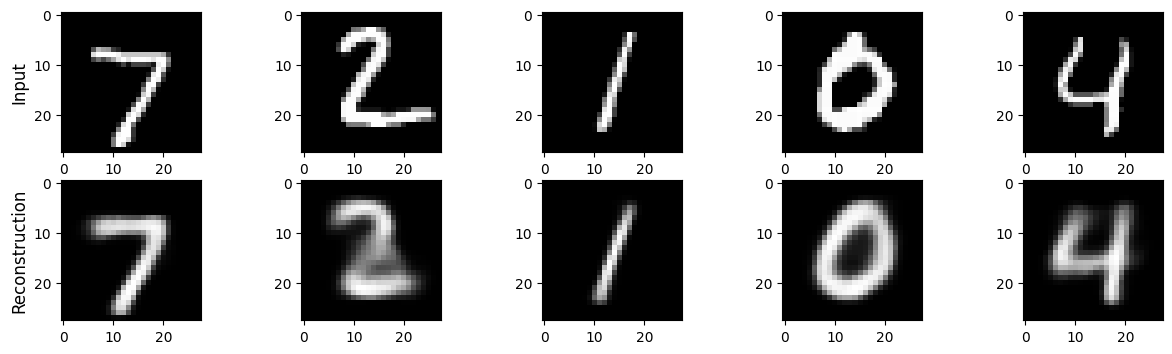

In [ ]:
test_inference(vae, idx=range(5))

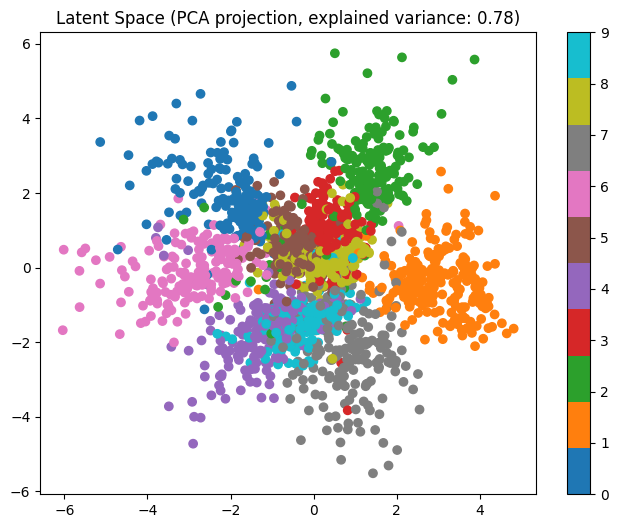

In [ ]:
plot_latent_space(vae)

Looks similar to the regular autoencoder, right?  BUT!  Now let's try perturbing our latent values a bit... ;-)

## "Sampling Robustness" of AE and VAE Latent Spaces

The reason that VAEs are often preferred over regular AEs for latent space representations when doing *generative* modeling is the tolerance that VAE latent spaces offer with respect to perturbation. (The KL regularization is what helps provide this).

Let's pick some points in latent space (by running images through the encoder), perturb them with a little noise, and decode the results...


Perturbing the regular autoencoder with strength = 2.0:


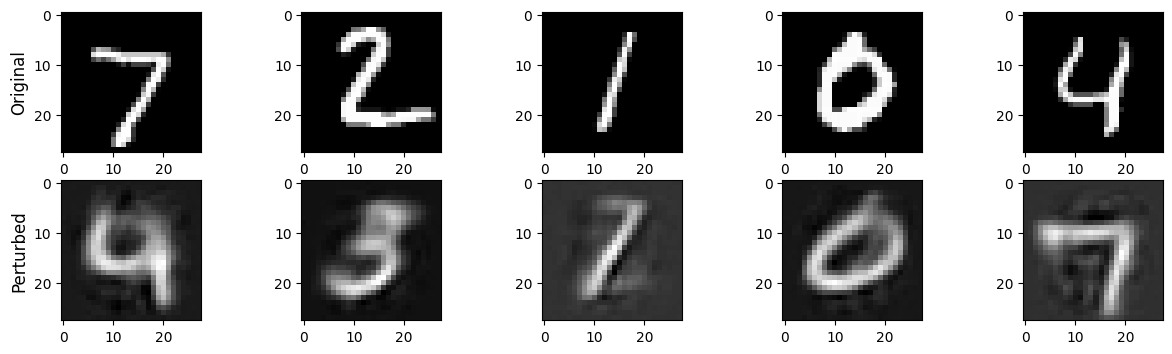

Perturbing the VAE with strength = 2.0:


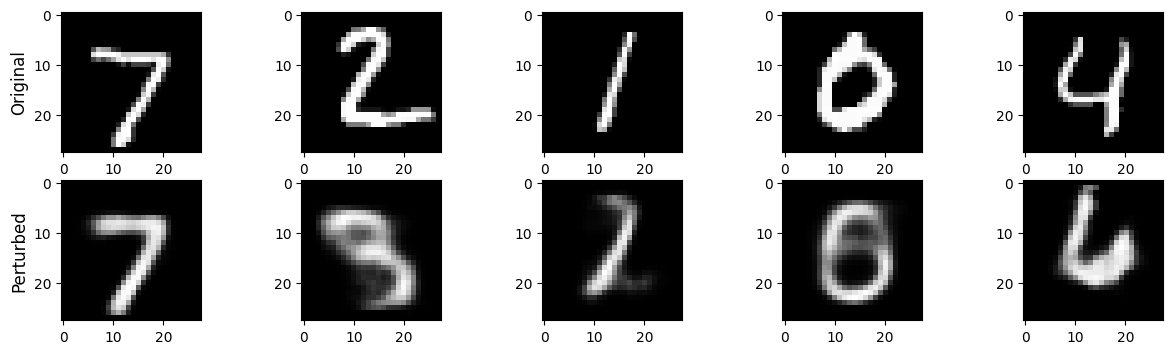

In [ ]:
#@title Code for `infer_perturb` viz tool
@torch.no_grad()
def infer_perturb(model, idx=None, strength=1.0):
    model.eval()
    if idx is None: idx = torch.randint(len(test_ds), (1,))[0]
    if isinstance(idx, int): idx = [idx]
    elif isinstance(idx, range): idx = list(idx)

    x_batch = torch.stack([test_ds[i][0] for i in idx]).to(model.device) # get some data
    if not model.use_conv: x_batch = x_batch.view(x_batch.size(0), -1)
    z = model.encoder(x_batch)
    if z.shape[-1] > model.latent_dim: z = z[:, :model.latent_dim] # for VAE, this chops off std values
    z_hat = z + strength * torch.randn_like(z)  # here's where we do the perturbation
    x_hat = model.decoder(z_hat)
    # make the visualization/plot...
    fig, axs = plt.subplots(2, len(idx), figsize=(3*len(idx), 4))
    if len(idx) == 1: axs = axs.reshape(2, 1)
    for i in range(len(idx)):
        axs[0,i].imshow(x_batch[i].view(28,28).cpu(), cmap='gray')
        axs[1,i].imshow(x_hat[i].view(28,28).cpu(), cmap='gray')
        if i == 0:
            axs[0,0].set_ylabel('Original', fontsize=12)
            axs[1,0].set_ylabel('Perturbed', fontsize=12)
    plt.show()
    model.train()

idx=range(5)
strength = 2.0
print(f"Perturbing the regular autoencoder with strength = {strength}:")
infer_perturb(autoencoder, idx=idx, strength=strength)
print(f"Perturbing the VAE with strength = {strength}:")
infer_perturb(vae, idx=idx, strength=1.0)

Notice the difference?  Depending on the random values you get, perturbations may cause the regular AE output to look like not-a-number, whereas the VAE output is probably more stable with respect to perturbations.  


Note also that without any final rescaling of outputs (e.g. via `nn.Sigmoid`), typically the output of the regular AE extends wayyy outside the [0,1] intensity bounds whereas the VAE's outputs are still properly bounded.


## More analysis: Add grid interpolation, viz, more.

Let's make a grid of points $z$ in latent space,  and see what they all **decode** to:

z_hat_batch.shape = torch.Size([225, 3])
grid.shape = torch.Size([3, 452, 452])


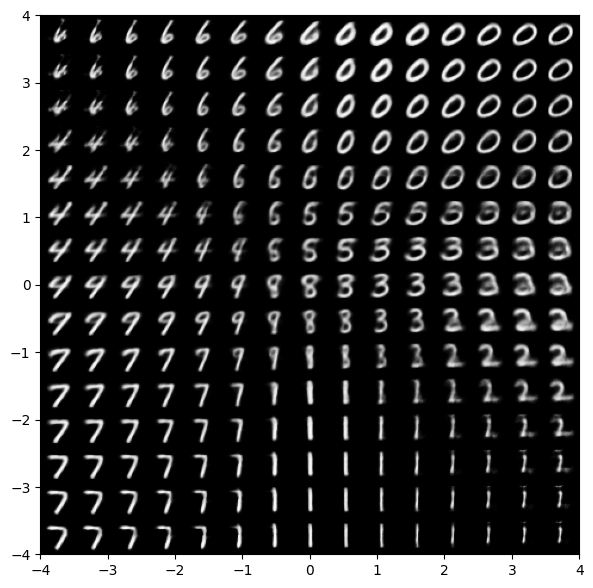

In [ ]:
#@title Code for `gen_grid` viz tool
def gen_grid(model, xmin=-4, xmax=4, nrow=15):
    zhats = []
    with torch.no_grad():
        for xcoord in torch.linspace(xmin,xmax,nrow):
            for ycoord in torch.linspace(xmin,xmax,nrow):
                z_hat = torch.zeros(model.latent_dim)
                z_hat[0], z_hat[1] = xcoord, ycoord
                zhats.append(z_hat)

        z_hat_batch = torch.vstack(zhats) # unsqueeze adds dummy color channel
        print("z_hat_batch.shape =",z_hat_batch.shape)
        x_hat = model.decoder(z_hat_batch)
        x_hat = x_hat.view(x_hat.size(0), 1, 28, 28)

    grid = torchvision.utils.make_grid(x_hat, nrow)
    print("grid.shape =",grid.shape)

    grid = rearrange(grid, 'c h w -> h w c')
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(grid.numpy(), extent=(xmin,xmax,xmin,xmax))
    plt.show()

gen_grid(model)

The VAE organized digit classes into separate regions with dark 'boundaries' between them. The unclear/dark areas represent spaces between digit classes - when we sample there, the VAE tries to decode something halfway between a 3 and an 8, which looks blended or unclear.

This shows both the power and limitation of VAEs: they create smooth, organized latent spaces, but we can't control which digit appears where. What if we want to explicitly tell the VAE 'generate a 7 in this region'? That's where conditional VAEs come in.


# 4. Conditional VAE, i.e. Adding Controls to the VAE
*i.e., Which number would you like to 'generate'?*


"Conditioning" means attaching controls to the model that, via training, it can learn to associate with specific kinds outputs. For example, we could do "class conditioning" where we tell it what class --- in our case, which digit -- we want the output to be.

The conditioning may take the form of adding or multiplying numbers to the activations, concatenating some controls,...lots of things. One general class of conditioning methods is often referred to as [FiLM layers](https://distill.pub/2018/feature-wise-transformations/), where FiLM stands for **F**eature-w**i**se **L**inear **M**odulation. Essentially it means we will apply our conditioning by both addition and multiplication.

How and where we apply the conditioning is up to us: we could apply it to the encoder, the latent space, and/or the decoder. We could include the conditioning signal in only one spot, or in between all layers. ...It kind of depends on what we want to do.  

We'll take a clue from [StyleGAN2](https://arxiv.org/abs/1912.04958v2) (even though it's a GAN!) and apply our conditioning all throughout the model.

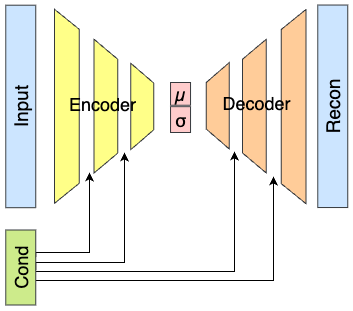

In [ ]:
# Here's one way to make a FiLM layer
class FiLM(nn.Module):
    def __init__(self, x_dim, cond_dim):
        super().__init__()
        self.gamma_gen = nn.Linear(cond_dim, x_dim)
        self.beta_gen  = nn.Linear(cond_dim, x_dim)

    def forward(self, x, cond):
        gamma = self.gamma_gen(cond)
        beta  = self.beta_gen(cond)
        return x * gamma + beta

We could do a conditional "regular autoencoder" but it would be kind of boring because whichever digit you ask for, say a 7, it'll just produce the exact same 7 every time.  We want some *variation* to the outputs, so let's make a conditional VAE

In [ ]:
# Conditional VAE

latent_dim = 4

n_hid = [256, 64]  # could imagine adding more layers

act = nn.GELU # this is popular in many models

# should we condition the encoder too?
# doing so may help give structure to the latent space
vae_encoder = nn.Sequential(    # same as before
                nn.Linear(28 * 28, n_hid[0]),
                act(),
                nn.Linear(n_hid[0], n_hid[1]),
                act(),
                nn.Linear(n_hid[1], 2*latent_dim),
                )

cond_dim = 10  # we'll use one-hot encoding for class conditioning; 10 classes


class EncoderCond(nn.Module):
    def __init__(self, latent_dim, n_hid, cond_dim):
        super().__init__()
        self.l1 = nn.Linear(28*28, n_hid[0])
        self.f1 = FiLM(n_hid[0], cond_dim)
        self.l2 = nn.Linear(n_hid[0], n_hid[1])
        self.f2 = FiLM(n_hid[1], cond_dim)
        self.l3 = nn.Linear(n_hid[1], 2*latent_dim)
        self.act = act()
    def forward(self, x, cond, debug=False):
        x = self.act( self.l1(x) )
        x = self.f1(x,cond)
        x = self.act( self.l2(x) )
        x = self.f2(x, cond)
        x = self.l3(x)
        if debug: print("leaving Encoder, x.shape =",x.shape)
        return x

# Let's try sticking a FiLM before each Linear layer in the Decoder.
# Oh, for the decoder we can't just use nn.Sequential anymore...
class DecoderCond(nn.Module):
    def __init__(self, latent_dim, n_hid, cond_dim):
        super().__init__()
        self.f1 = FiLM(latent_dim, cond_dim)
        self.l1 = nn.Linear(latent_dim, n_hid[1])
        self.f2 = FiLM(n_hid[1], cond_dim)
        self.l2 = nn.Linear(n_hid[1], n_hid[0])
        self.f3 = FiLM(n_hid[0], cond_dim)
        self.l3 = nn.Linear(n_hid[0], 28 * 28)
        self.act = act()

    def forward(self, x, cond, debug=False):
        if debug: print("Debug: 1 x.shape =",x.shape)
        x = self.f1(x, cond)
        x = self.act( self.l1(x) )
        x = self.f2(x, cond)
        x = self.act( self.l2( x ) )
        x = self.f3(x, cond)
        x = self.l3( x )
        x = torch.sigmoid(x) # needed if you want to use BCE loss
        return x

In [ ]:
# instead of nn.Module, we use L.LightningModule
class CondVAEModel(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.ema_loss = 0.06
        self.use_conv = False # legacy variable used by our other viz tools

    def reparam_sample(self, mu, log_var):
        std = torch.exp(0.5*log_var).sqrt() # why the 0.5?
        noise = torch.randn_like(std)       # the "noise"
        return mu + std * noise

    def forward(self, x, cond):
        z = self.encoder(x, cond)
        i_half = z.shape[-1]//2
        mu, log_var = z[:,:i_half],  z[:,i_half:]
        z_hat = self.reparam_sample(mu, log_var)
        x_hat = self.decoder(z_hat, cond)
        return z, x_hat, mu, log_var, z_hat

    def gen(self, y, n_gen=1):
        # given target y samples from latent space and decodes
        cond = F.one_hot(torch.tensor(y), num_classes=10).float()
        mu = 4*torch.randn((n_gen, latent_dim))
        log_var = 2*torch.randn((n_gen, latent_dim))
        z_hat = self.reparam_sample(mu, log_var)
        x_hat = self.decoder(z_hat, cond)
        return x_hat

    def _compute_loss(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        cond = F.one_hot(y, num_classes=10).float().to(x.device)
        z, x_hat, mu, log_var, z_hat = self.forward(x, cond)
        recon_loss = nn.functional.binary_cross_entropy(x_hat, x)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        scrunch_factor = 0.001
        loss = recon_loss + (kl_loss * scrunch_factor)
        return loss, recon_loss, kl_loss

    def training_step(self, batch, batch_idx):
        loss, recon_loss, kl_loss = self._compute_loss(batch, batch_idx)
        with torch.no_grad():
            self.ema_loss = 0.99*self.ema_loss + 0.01*loss.detach().item()
            self.log('ema_loss', self.ema_loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, recon_loss, kl_loss = self._compute_loss(batch, batch_idx)
        self.log('val_loss', loss)
        self.log('val_recon_loss', recon_loss)
        self.log('val_kl_loss', kl_loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

    def on_validation_epoch_end(self, demo_every=1):
        if self.current_epoch % demo_every == 0:  # log every this many epochs
            fig = test_inference(self, idx=range(5), return_fig=True)
            self.logger.experiment.log({"reconstructions": wandb.Image(fig), "epoch": self.current_epoch})
            plt.close(fig)  # clean up

### Train the conditional VAE

In [ ]:
vae_encoder_cond = EncoderCond(latent_dim, n_hid, cond_dim)
vae_decoder_cond = DecoderCond(latent_dim, n_hid, cond_dim)
cond_vae = CondVAEModel(vae_encoder_cond, vae_decoder_cond)

epochs = 10 # feel free to run longer
wandb.finish() # just clear out any previous unfinished runs
wandb_logger = WandbLogger(log_model="all", project='cvae_tut')
wandb_logger.watch(cond_vae) # this thing complains too much upon re-runs, just ignore it and keep going
trainer = L.Trainer(max_epochs=epochs, devices="auto", logger=wandb_logger, callbacks=RichProgressBar(leave=True))
trainer.fit(model=cond_vae, train_dataloaders=train_dl, val_dataloaders=val_dl)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL

┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type        ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ encoder │ EncoderCond │  224 K │ train │
│ 1 │ decoder │ DecoderCond │  225 K │ train │
└───┴─────────┴─────────────┴────────┴───────┘

Trainable params: 450 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 450 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 25                                                                                          
Modules in eval mode: 0

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Let's take a look at Decoder inference when sampling a grid of points in latent space:

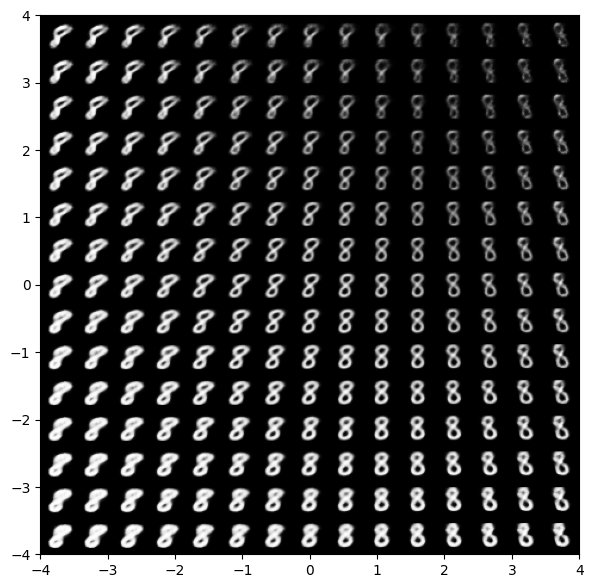

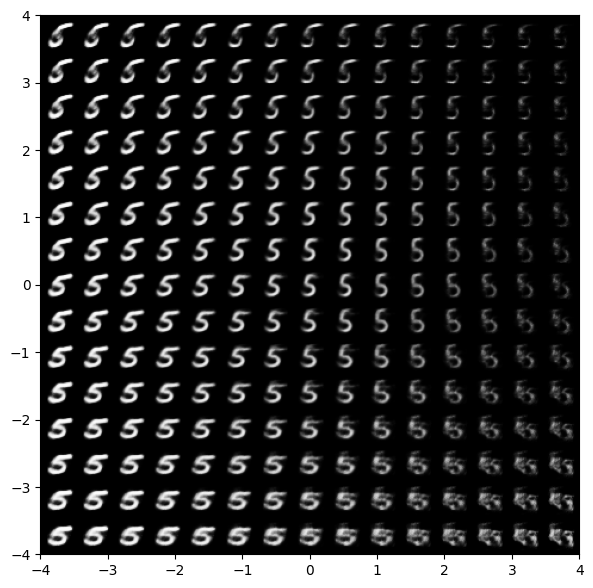

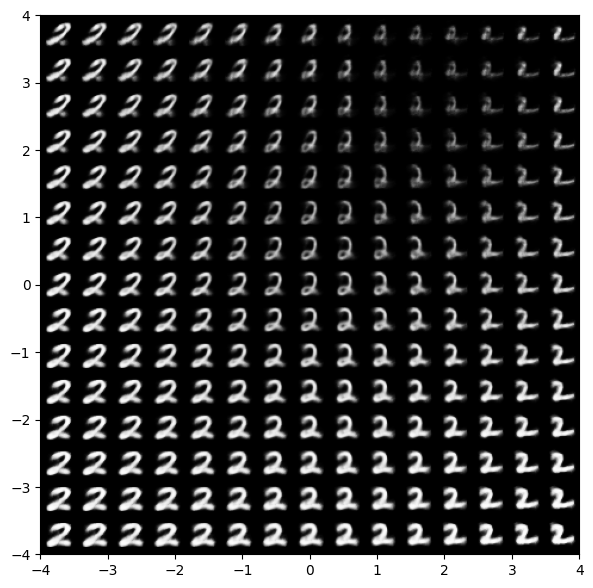

In [ ]:
#@title Code for `cond_grid` viz tool
def cond_grid(model, y):
    cond = F.one_hot(torch.tensor(y), num_classes=10).float()
    nrow = 15
    xmin, xmax = -4,4
    zhats = []
    with torch.no_grad():
        for xcoord in torch.linspace(xmin,xmax,nrow):
            for ycoord in torch.linspace(xmin,xmax,nrow):
                z_hat = torch.tensor([xcoord,ycoord,0.0,0.0])#.to(device)
                zhats.append(z_hat)

        z_hat_batch = torch.vstack(zhats).unsqueeze(1) # unsqueeze adds dummy color channel
        x_hat = model.decoder(z_hat_batch, cond)
        x_hat = x_hat.view(x_hat.size(0), 1, 28, 28)

    grid = torchvision.utils.make_grid(x_hat, nrow)
    #print("grid.shape =",grid.shape)
    grid = rearrange(grid, 'c h w -> h w c')
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(grid.numpy(), extent=(xmin,xmax,xmin,xmax))
    plt.show()

cond_grid(cond_vae, 8)
cond_grid(cond_vae, 5)
cond_grid(cond_vae, 2)

So we see that the latent space we used previously becomes entirely occupied by the digit we condition on, but we get different "properties" of that digit such as tilt, boldness, "font", etc. In other words, *translations in latent space amount to changes in style!*

# Exercises

For the generative models we'll look at later, they typically use *unconditional* VAEs (i.e. regular VAEs) to compress to latent space,and then conditional generative models that operate within that space.  Thus, these excercises are intended to be applied to the *unconditional* VAE, not the conditional one.

Feel free to use LLM tools to assist you.

## Exercise 3: Train to equilibrium & save
1. (Re-)Train the VAE model for (many) more epochs, until the validation losses "flatten out". (Could be 100 or more; you experiment.)  
2. Mount your Google Drive account (see "Commands" in the top left, search on "Mount Drive") and [save a checkpoint](https://lightning.ai/docs/pytorch/stable/common/checkpointing_basic.html) of the model at this final state to Google Drive. Use a filename with the following syntax: `vae_ep{max_epoch}_sf{scrunch_factor}.ckpt`


## Exercise 4: Explore Recon vs. Regularization
Explore the trade-off between reconstruction accuracy and latent space regularization.
1. Try these additional values `scrunch_factor`: `[0.0, 1e-4, 1e-2]`, training until the losses flatten out.  (Note that `0.0`, i.e. no regularization, should produce the same as a "vanilla autoencoder".) Save each model checkpoint for these values to GDrive as you did in the previous exercise. ...we will use these checkpoints later!
2. Analysis: Which value(s) yielded the lowest reconstruction loss?  Which gave the lowesst regularization loss?  


# Summary

This lesson introduced autoencoders as key part of the pipeline for efficient modern generative models. Key takeaways:

**Core Concept:** Autoencoders learn compressed latent representations by forcing data through an encoding bottleneck, then reconstructing the original input. This latent space captures the essential structure of the data distribution.

**Three Main Variants:**
- **Vanilla Autoencoder:** Basic reconstruction with MSE loss, but latent space is "lumpy" and unsuitable for generation
- **VAE:** Adds probabilistic structure with Gaussian priors and KL regularization, creating smooth, sampleable latent spaces
- **Conditional VAE:** Enables controlled generation by conditioning on class label inputs (we hooked these up using FiLM layers)

**Why This Matters for Generative Models:** VAEs create well-structured latent spaces that modern generative models (like Stable Diffusion) operate within. Instead of working directly with high-dimensional images, these models learn to generate in the compressed latent space, then decode to final outputs. The VAE's encoder-decoder architecture and smooth latent representations are essential building blocks for flow matching and diffusion models.

Note that for generative latent models, we typically use *unconditional* VAEs to learn the latent space compression, then apply conditioning at the generative model level that operates within that space.

---
***Thus ends the main lesson. The \_optional\_ Appendix that follows introduces vector quantization.***

# Appendix: Vector Quantized VAE (VQ-VAE)
*2025: I don't know if we'll need to learn the VQVAE or not this semester. That's why it's an "appendix".*

> Point of Order: I think they should drop the second "V" from "VQ-VAE": in no sense is it variational. It is *not* a VAE, rather it is a VQ-*AE*: it is an autoencoder for which, during training, points in latent space are replaced by their nearest "codebook" vectors, i.e. it will deterministically "snap" encoded latent point to the nearest codebook vector, and deterministically reconstruct from that. BTW, this determinism is why the loss for VQ-VAE is MSE, not BCE! During inference for generation, you *can* give it non-codebook latent points; the results will look a lot like the codebook values though!

For the VAE, we forced the distribution of points in latent space (what the smart people call the "prior" distribution, though some of us see this a "posterior" distribution since it's derived from the data, but I digress) was fixed to be a multidimensional gaussian.

But, maybe we want something a little more flexible than that. Another way to enforce a tractable probability distribution (i.e. besides assuming it's gaussian) is to quantize it.  So that's what we're going to do. We're basically going to try to cluster points -- "vectors" -- around a finite number of "codebook vectors".  Think of the codebook vectors as "team captains" or "tribal chieftans".  Eventually we'll start using the codebook vectors as "stand-ins" (i.e proxies, i.e.,....some theological term...) for the vectors in their vicinity. Doing so will form the "quantization" we're after. It will be an approximation, but hopefully it'll be so good you won't even notice. If you want to get into it, see the first part of [my blog post on Residual Vector Quantization](https://drscotthawley.github.io/blog/posts/2023-06-12-RVQ.html), which starts by talking about regular VQ.

The trick is going to be handling the quantization in a way that's *differentiable*. You might think "differential quantization" sounds like an oxymoron, and you'd be right. ;-) But there's a cheap workaround that works amazingly well.

What's going to happen is, when we encode into latent space, we'll replace the point with the *index that points to* the nearest vector in the codebook.  And we'll allow the codebook to evolve as we train.  Note that "nearest to" implies a nearest-neighbor algorithm, which can be slow, but we'll only be using it between one batch of z's at a time and our limited set of codebook vectors.


### VQ Loss Function

TODO: add this section, and note about the "pass-through" effect to do backpropagation despite the quantization.

## Code
(Best if you just install Lucidrains' [`vector-quantize-pytorch`](https://github.com/lucidrains/vector-quantize-pytorch/blob/146810e271f435daa3834edd9473be050bc04647/vector_quantize_pytorch/vector_quantize_pytorch.py) package instead of my code. ;-) I'm kidding. )

The encoder and decoder will look a lot like our earlier VAE, but the stuff in the middle will change

In [ ]:
latent_dim = 2 # we'll use 2 for this just because I want to make sure the 'grid' images we make are easily interpretable

n_hid = [256, 64, 16]  # could imagine adding more layers

act = nn.LeakyReLU # works ok.


encoder = nn.Sequential(
                nn.Linear(28 * 28, n_hid[0]),
                nn.BatchNorm1d(n_hid[0]),  # Adding BatchNorm doesn't really help much tbh, you could take it out.
                act(),
                nn.Linear(n_hid[0], n_hid[1]),
                nn.BatchNorm1d(n_hid[1]),
                act(),
                nn.Linear(n_hid[1], n_hid[-1]),
                nn.BatchNorm1d(n_hid[-1]),
                act(),
                nn.Linear(n_hid[-1], latent_dim), # no more mu/log_var b/c it's not a gaussian
                )

# decoder is same as before
decoder = nn.Sequential(
                nn.Linear(latent_dim, n_hid[-1]),
                nn.BatchNorm1d(n_hid[-1]),
                act(),
                nn.Linear(n_hid[-1], n_hid[1]),
                nn.BatchNorm1d(n_hid[1]),
                act(),
                nn.Linear(n_hid[1], n_hid[0]),
                nn.BatchNorm1d(n_hid[0]),
                act(),
                nn.Linear(n_hid[0], 28 * 28),
                nn.Sigmoid(), # optional forcing to [0,1]
                )


class VQVAEModel(L.LightningModule):
    def __init__(self, encoder, decoder, cb_len=100):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.cb_len = cb_len  # codebook length, e.g. # of classes, or more
        self.cb = nn.Embedding(cb_len, latent_dim) # just a Parameter + random initialization. use .weight for values
        # Note: in practice one sees people initializing the codebook self.cb via K-means, but...we're not gonna

    def get_nearest_cbv(self, z):
        "get nearest codebook vectors"
        dist = torch.cdist(z, self.cb.weight)
        idx_q = torch.argmin(dist, dim=-1)
        z_q = self.cb.weight[idx_q]
        return z_q

    def forward(self,x):
        z = self.encoder(x)
        z_q = self.get_nearest_cbv(z)
        z_q_d = z + (z_q - z).detach()    # straight-through estimation; use only to pass to decoder
        x_hat = self.decoder(z_q_d)
        return z, z_q, x_hat

    def pred_and_log(self, batch, batch_idx, log_prefix=''):
        x, y = batch
        x = x.view(x.size(0), -1)
        z, z_q, x_hat = self.forward(x)

        recon_loss = 2*F.mse_loss(x_hat, x)
        cb_loss   = 0.5*F.mse_loss(z.detach(), z_q)
        beta = 0.1
        comm_loss = F.mse_loss(z,          z_q.detach())  * beta
        loss = recon_loss + cb_loss + comm_loss

        self.log(f'{log_prefix}loss', loss, prog_bar=True)
        self.log(f'{log_prefix}recon_loss', recon_loss)
        self.log(F'{log_prefix}cb_loss', cb_loss)
        self.log(F'{log_prefix}comm_loss', comm_loss)
        #print("self.cb.weight = ",self.cb.weight.cpu().detach().numpy())

        return loss

    def training_step(self, batch, batch_idx):
       return self.pred_and_log(batch, batch_idx, log_prefix='train/')


    def validation_step(self, batch, batch_idx):
        return self.pred_and_log(batch, batch_idx, log_prefix='val/')

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=5e-3)


vqvae = VQVAEModel(encoder, decoder)
model = vqvae

In [ ]:
wandb.finish()
wandb_logger = WandbLogger(log_model="all", project='vqvae_tut')
try:
    wandb_logger.watch(model) # this thing complains too much upon re-runs, just ignore it and keep going
except:
    pass

ema_loss,▇█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_kl_loss,▁▆▇▇▇█████
val_loss,█▃▂▂▂▁▁▁▁▁
val_recon_loss,█▃▂▂▂▁▁▁▁▁
ema_loss,0.13933
epoch,9
trainer/global_step,4689
val_kl_loss,4.81332
val_loss,0.13951


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
epochs = 10
trainer = L.Trainer(max_epochs=epochs, devices="auto", logger=wandb_logger, callbacks=RichProgressBar(leave=True))
trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)
wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type       ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ encoder │ Sequential │  219 K │ train │
│ 1 │ decoder │ Sequential │  219 K │ train │
│ 2 │ cb      │ Embedding  │    200 │ train │
└───┴─────────┴────────────┴────────┴───────┘

Trainable params: 439 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 439 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 24                                                                                          
Modules in eval mode: 0

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇██
train/cb_loss,▁▁▂▃▁▂▃▂▃▃▃▃▃▅▃▃▄▄▆▃▃▅▃▄▄▄▄▄▆▇▆▇▄█▅▇▅▄▅▆
train/comm_loss,▁▁▁▁▂▂▂▁▂▂▂▂▃▃▂▄▄▃▃▃▂▃▃▄▄▄▃▅█▄▄▅▄▄▄▃▄▄▃▄
train/loss,▆▆▄▂▃▃▃▁▂▃▅▄▄▆▄▆▂▆▄▅▃▃▅▄▅▆▅▆▄▅▅▃▆▅█▁█▆▄▄
train/recon_loss,████▆▄█▅▂▃▅▄▅▃▃▅▅▄▃▆▃▂▄▅▅▂▄▃▄▄▅▁▁▄▂▅▃▃▂▄
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val/cb_loss,▁▂▃▅▆▅▆▇▇█
val/comm_loss,▁▂▃▅▆▅▆▇▇█
val/loss,▅▁▁▃▆▂▄▅▆█
val/recon_loss,█▅▄▃▃▂▂▁▂▁
epoch,9


z, z_q = [array([[ 1.5978222, -2.3192143]], dtype=float32), array([[ 1.4235866, -2.3783786]], dtype=float32)]
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = 0.0008366581168957055, max(x) = 0.9186272025108337


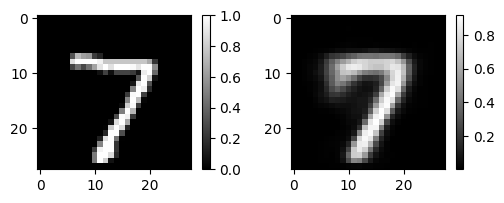

z, z_q = [array([[1.1384937 , 0.48225403]], dtype=float32), array([[1.2361333 , 0.25847682]], dtype=float32)]
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = 0.0007737944251857698, max(x) = 0.7570145130157471


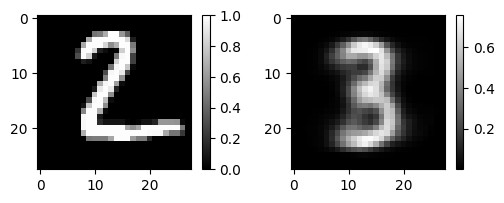

In [ ]:
#@title viz code for testing VQVAE inference
@torch.no_grad()
def test_inference2(model, idx=None):
    model.eval()
    "like test_inference but for vqvae"
    if idx is None: idx = torch.randint( len(test_ds), (1,) )[0]
    x, y = test_ds[idx]
    x = x.view(x.size(0), -1)
    z, z_q, x_hat = model.forward(x)
    print("z, z_q =",[g.detach().cpu().numpy() for g in [z, z_q]])
    x_hat = x_hat.view(x.size(0), 28, -1)
    x = x.view(x.size(0), 28, -1)
    show_xs([x,x_hat])

test_inference2(vqvae, idx=0)
test_inference2(vqvae, idx=1)

Let's do the "grid of interpolation" thing again, only let's also show the locations (projected on to the plane) of the nearest codebook vectors for each point on our "interpolation grid".

We'll show the difference between what happens when you decode from "any" location in the latent space, vs. what happens if you "quantize" those locations first by filling in codebook vector values: Not alot!  That's because our activation functions are piecewise-linear, so the values set at the codebook vector locations get applied throughout the "region" regardless of whether you quantize or not.

z_batch.shape = torch.Size([81, 2])
cell_size= 1.0


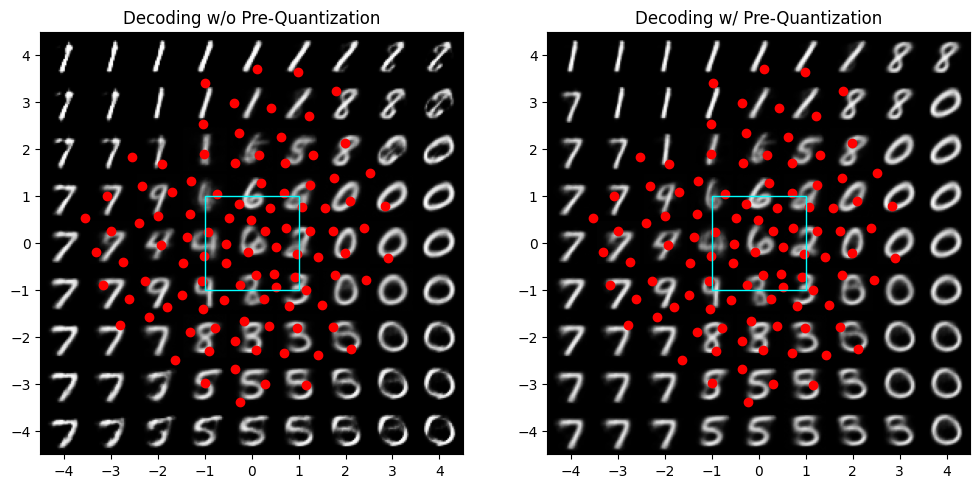

In [ ]:
#@title Code for `gen_grid2` VQVAE grid sampling vizualization
import matplotlib.patches as patches
from scipy.spatial import Voronoi, voronoi_plot_2d


@torch.no_grad()
def gen_grid2(model, xmin=-4, xmax=4, nrow=9):
    zs = []
    for xcoord in torch.linspace(xmin,xmax,nrow):
        for ycoord in torch.linspace(xmin,xmax,nrow):
            #print("xcoord, ycoord =", xcoord, ycoord)
            z = torch.tensor([xcoord,ycoord]+[0]*(latent_dim-2)) # interpolate in a plane # points to encode
            zs.append(z)

    z_batch = torch.vstack(zs) # unsqueeze adds dummy color channel
    print("z_batch.shape =",z_batch.shape)
    nearest_cbvs = vqvae.get_nearest_cbv(z_batch)
    x_hat = vqvae.decoder(z_batch)
    x_hat = x_hat.view(x_hat.size(0), 1, 28, 28)

    x_hat_cbvs = vqvae.decoder(nearest_cbvs).view(x_hat.size(0), 1, 28, 28)

    # ahhhh we have to line up the MIDDLE of each little image with its coordinate value, so subtract & add half a 'grid cell'
    cell_size = (xmax-xmin)/(nrow-1)
    print('cell_size=',cell_size)
    xmin = xmin - cell_size/2
    xmax = xmax + cell_size/2

    fig, ax = plt.subplots(figsize=(12,6), ncols=2)
    for i, recon in enumerate([x_hat, x_hat_cbvs]):
        grid = torchvision.utils.make_grid(recon, nrow)
        grid = rearrange(grid, 'c h w -> h w c')
        ax[0].title.set_text('Decoding w/o Pre-Quantization')
        ax[1].title.set_text('Decoding w/ Pre-Quantization')

        ax[i].imshow(grid.numpy(), extent=(xmin,xmax,xmin,xmax))

        # superimpose  codebook vectors onto the image
        ax[i].scatter(model.cb.weight[:,0],model.cb.weight[:,1],c='r')
        # TODO: add Vornonoi cells?
        #vor = Voronoi(np.vstack((df.iloc[i, ::2], df.iloc[i, 1::2])).T)

        # add cyan box of where we're about to zoom to
        rect = patches.Rectangle((-1, -1), 2, 2, linewidth=1, edgecolor='cyan', facecolor='none')
        ax[i].add_patch(rect)

        ax[i].set_xlim(xmin,xmax)
        ax[i].set_ylim(xmin,xmax)
    plt.show()


gen_grid2(vqvae, xmin=-4,xmax=4)

Comparing the images on the right and left, we see that they're similar but not exactly the same.

That's a bit of a jumble, so let's "zoom in" to the box shown in the middle of the above picture:

z_batch.shape = torch.Size([81, 2])
cell_size= 0.25


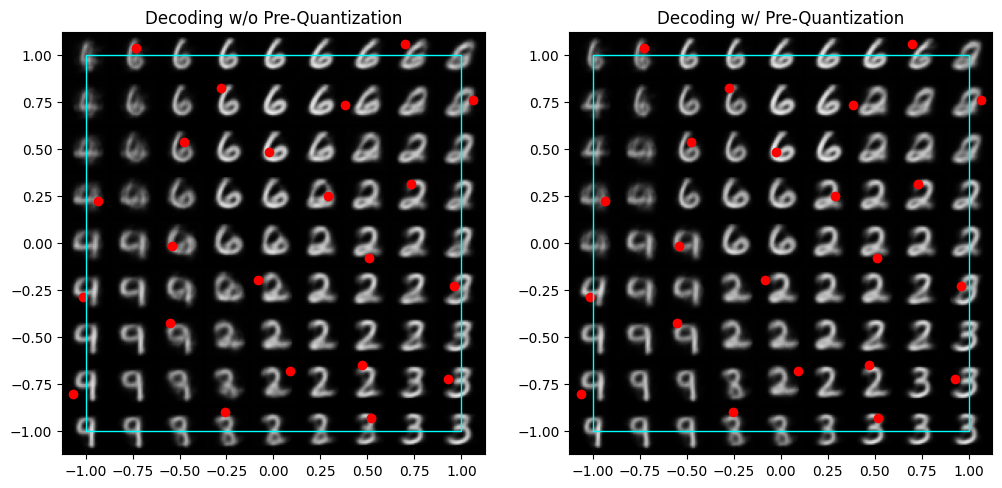

In [ ]:
gen_grid2(vqvae, xmin=-1, xmax=1)

TODO: Hmmm... Seems like the red dots *should* appear in the *middle* of each region, but they more often appear at the boundaries between regions.  Not sure why that is. Need to figure out display of locations of the dots!

## For further investigation:
- VQ-VAE dictionary updates with Exponential Moving Averages